In [3]:
# STEP 1: Downgrade NumPy and install compatible versions of required packages
!pip install "numpy<2" batman-package astropy lightkurve scikit-learn --upgrade --quiet




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 16.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.4/270.4 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [6]:
!pip install lightkurve

In [1]:
import numpy as np
import batman
import lightkurve as lk
import astropy
import sklearn

print("NumPy version:", np.__version__)
print("Batman version:", batman.__version__)
print("Lightkurve version:", lk.__version__)
print("Astropy version:", astropy.__version__)
print("Scikit-learn version:", sklearn.__version__)

NumPy version: 1.26.4
Batman version: 2.5.1
Lightkurve version: 2.5.0
Astropy version: 7.0.1
Scikit-learn version: 1.6.1


In [3]:
# Import more stuff
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import BoxLeastSquares
from scipy.signal import medfilt, savgol_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

/usr/local/lib/python3.11/dist-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 50 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


NameError: name 'pd' is not defined

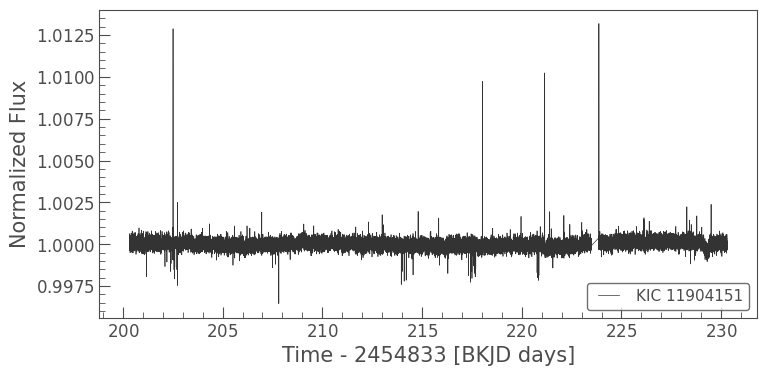

In [2]:
# =====================
# 2. LOAD TESS/K2/Kepler DATA (via lightkurve)
# =====================
# Example: Load light curve for a known exoplanet
# Step 1: Load Lightcurve (TESS or Kepler)
target_name = "Kepler-10"  # Change this to any Kepler or TESS target
lc = lk.search_lightcurve(target_name, mission="Kepler").download()

# Convert to pandas DataFrame
df = pd.DataFrame({
    'time': lc.time.value,
    'flux': lc.flux.value
})

df.to_csv('sample_data/kepler_exoplanet_lightcurve.csv')
#lc = lc.normalize().remove_nans()
#lc.plot(title=f"Normalized Lightcurve for {target_name}")

#search_result = lk.search_lightcurve("Kepler-10", mission='Kepler')
#lc = search_result.download()
#lc = lc.normalize().remove_nans().flatten()




In [10]:
# Preview the dataset
print("Head of Data:")
print(df.head())
print("\nData Summary:")
print(df.describe())

Head of Data:
         time      flux
0  200.324085  0.999943
1  200.324766  1.000172
2  200.325447  1.000077
3  200.326128  0.999743
4  200.326809  0.999679

Data Summary:
               time          flux
count  43361.000000  43361.000000
mean     215.206470      1.000001
std        8.656105      0.000248
min      200.324085      0.996517
25%      207.723792      0.999860
50%      215.130963      0.999999
75%      222.530614      1.000142
max      230.299402      1.013064


In [11]:

# Check for missing values
print("\nMissing Values:")
print(df.isna().sum())


Missing Values:
time    0
flux    0
dtype: int64


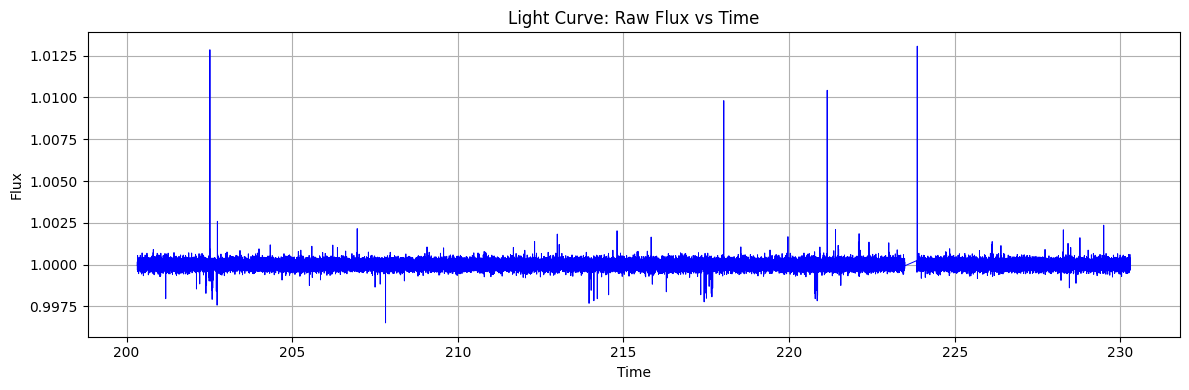

In [12]:
#================================
# Exploratory Data Analysis of LightCurve
#======================================
# Basic line plot: flux over time
plt.figure(figsize=(12, 4))
plt.plot(df['time'], df['flux'], color='blue', linewidth=0.7)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Light Curve: Raw Flux vs Time")
plt.grid(True)
plt.tight_layout()
plt.show()

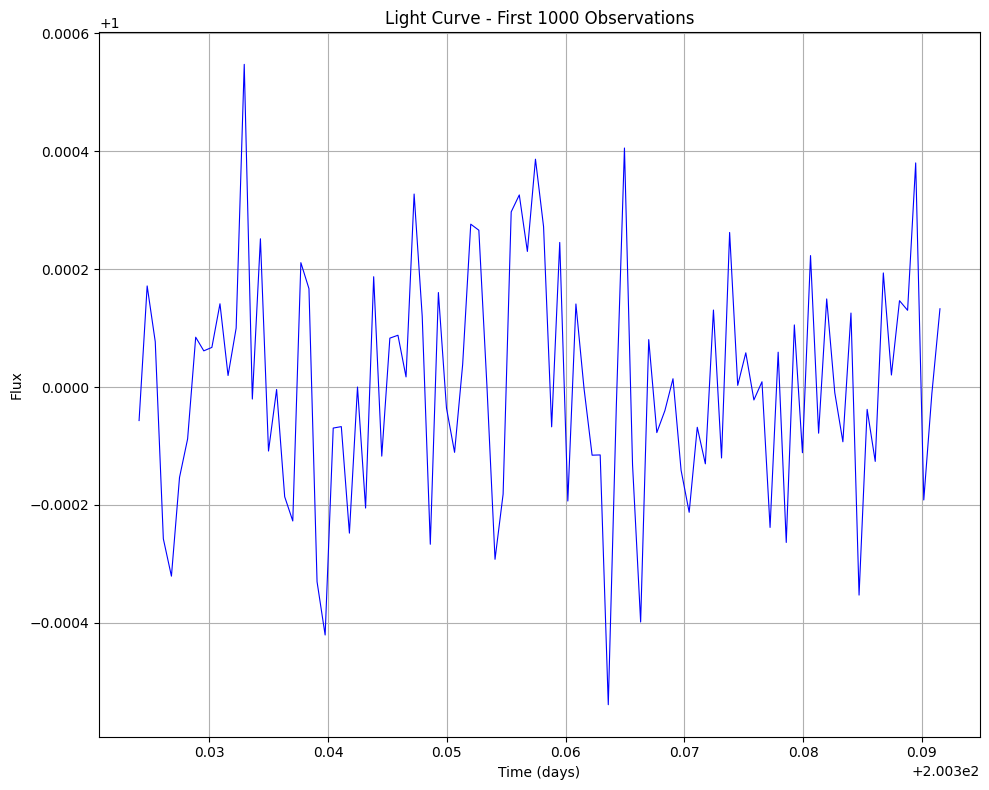

In [20]:
# =====================
# PLOT FIRST 1000 OBSERVATIONS (RAW FLUX)
# =====================
subset = df.iloc[:100]  # first 1000 rows

plt.figure(figsize=(10, 8))
plt.plot(subset['time'], subset['flux'], color='blue', linewidth=0.8)
plt.xlabel("Time (days)")
plt.ylabel("Flux")
plt.title("Light Curve - First 1000 Observations")
plt.grid(True)
plt.tight_layout()
plt.show()


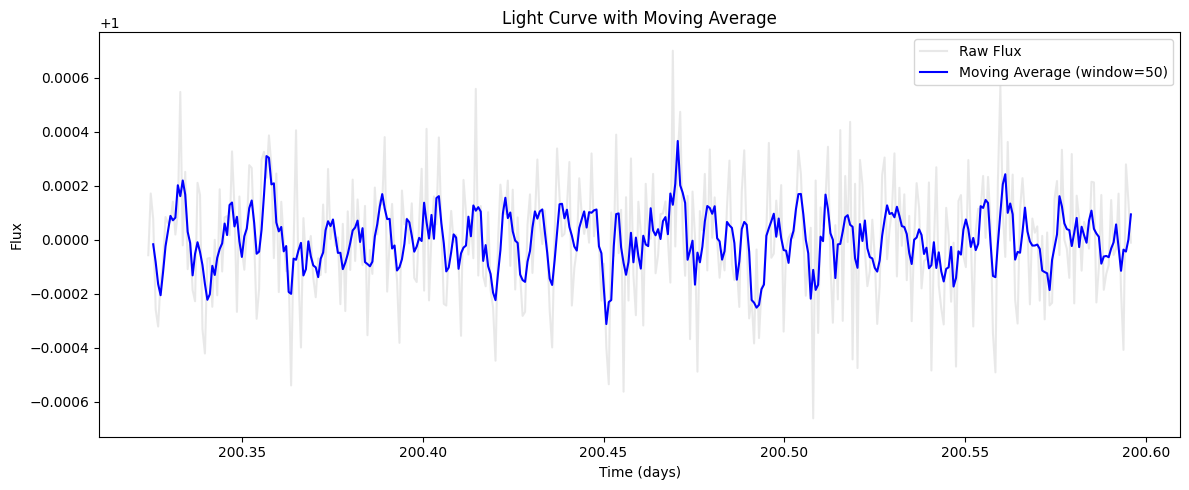

In [30]:
# Compute moving average (e.g., over a window of 50 points)
df['flux_ma'] = df['flux'].rolling(window=4, center=True).mean()
subset = df.iloc[:400]  # first 1000 rows

# Plot both raw flux and moving average
plt.figure(figsize=(12, 5))
plt.plot(subset['time'], subset['flux'], label='Raw Flux', color='lightgray', alpha=0.5)
plt.plot(subset['time'], subset['flux_ma'], label='Moving Average (window=50)', color='blue')
plt.xlabel('Time (days)')
plt.ylabel('Flux')
plt.title('Light Curve with Moving Average')
plt.legend()
plt.tight_layout()
plt.show()


In [31]:

# =====================
# 3. PREPROCESSING & SMOOTHING
# =====================
df['flux_med'] = df['flux'] / medfilt(df['flux'], kernel_size=101)
df['flux_smooth'] = savgol_filter(df['flux_med'], 101, 3)

# =====================
# 4. TRANSIT DETECTION (BLS)
# =====================
time = df['time'].values
flux = df['flux_smooth'].values
bls = BoxLeastSquares(time, flux)
periods = np.linspace(0.5, 30, 10000)
durations = 0.1 * periods
results = bls.power(periods, durations)

best_period = results.period[np.argmax(results.power)]
best_t0 = results.transit_time[np.argmax(results.power)]
best_duration = results.duration[np.argmax(results.power)]

print("Best period:", best_period)

# =====================
# 5. PLOT BLS POWER & FOLDED CURVE
# =====================
plt.figure(figsize=(10, 4))
plt.plot(results.period, results.power)
plt.xlabel("Period (days)")
plt.ylabel("BLS Power")
plt.title("BLS Periodogram")
plt.tight_layout()
plt.show()

# Folded light curve
phase = ((time - best_t0 + 0.5 * best_period) % best_period) / best_period
plt.figure(figsize=(10, 4))
plt.scatter(phase, flux, s=3, alpha=0.6)
plt.xlabel("Phase")
plt.ylabel("Normalized Flux")
plt.title("Phase-Folded Light Curve")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# =====================
# 6. TRANSIT FITTING WITH BATMAN
# =====================
params = batman.TransitParams()
params.t0 = best_t0
params.per = best_period
params.rp = 0.1
params.a = 15
params.inc = 87
params.ecc = 0
params.w = 90
params.u = [0.1, 0.3]
params.limb_dark = "quadratic"

model_time = np.linspace(min(time), max(time), 1000)
m = batman.TransitModel(params, model_time)
model_flux = m.light_curve(params)

plt.figure(figsize=(10, 4))
plt.plot(model_time, model_flux, label="Transit Model")
plt.scatter(time, flux, s=2, alpha=0.4, label="Observed")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Transit Fit")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# =====================
# 7. FEATURE EXTRACTION FOR ML
# =====================
features = pd.DataFrame({
    'period': [best_period],
    'duration': [best_duration],
    'depth': [np.min(model_flux)],
    'bls_power': [np.max(results.power)]
})
labels = [1]  # 1 = transit, 0 = non-transit (for demonstration)

# =====================
# 8. ML CLASSIFICATION (Random Forest)
# =====================
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


ValueError: The maximum transit duration must be shorter than the minimum period